In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
import os
import wandb


# Hyperparameters
mb_size = 64
Z_dim = 1000
h_dim = 128
lr = 1e-3

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out



# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg
    


def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_vanila_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)



########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = my_bce_loss

if wandb_log: 
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 100

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)


# Inference    
# G.load_state_dict(torch.load('checkpoints/G_best.pth'))
# G.eval()

# save_sample(G, "best", mb_size, Z_dim)

D_loss,▇▂▁▁▁▁▂▂▃█
D_loss_fake,▇▃▁▁▁▁▂▂▃█
D_loss_real,█▂▁▁▁▁▂▂▄█
G_loss,▂▆▆▆▇█▆▅▇▁
D_loss,0.10583
D_loss_fake,0.04797
D_loss_real,0.05786
G_loss,6.57635


100%|██████████| 938/938 [00:08<00:00, 111.43it/s]


epoch0; D_loss: 0.0685; G_loss: 7.2041
Saved Best Models at epoch 0 | G_loss: 7.2041


100%|██████████| 938/938 [00:08<00:00, 116.31it/s]


epoch1; D_loss: 0.0299; G_loss: 6.1031
Saved Best Models at epoch 1 | G_loss: 6.1031


100%|██████████| 938/938 [00:07<00:00, 129.64it/s]


epoch2; D_loss: 0.0473; G_loss: 5.4639
Saved Best Models at epoch 2 | G_loss: 5.4639


100%|██████████| 938/938 [00:07<00:00, 129.33it/s]


epoch3; D_loss: 0.0799; G_loss: 6.0082


100%|██████████| 938/938 [00:08<00:00, 115.65it/s]


epoch4; D_loss: 0.1515; G_loss: 5.3884
Saved Best Models at epoch 4 | G_loss: 5.3884


100%|██████████| 938/938 [00:07<00:00, 124.62it/s]


epoch5; D_loss: 0.2654; G_loss: 4.8359
Saved Best Models at epoch 5 | G_loss: 4.8359


100%|██████████| 938/938 [00:07<00:00, 118.90it/s]


epoch6; D_loss: 0.3881; G_loss: 4.1792
Saved Best Models at epoch 6 | G_loss: 4.1792


100%|██████████| 938/938 [00:08<00:00, 114.50it/s]


epoch7; D_loss: 0.5203; G_loss: 3.4783
Saved Best Models at epoch 7 | G_loss: 3.4783


100%|██████████| 938/938 [00:07<00:00, 124.38it/s]


epoch8; D_loss: 0.5619; G_loss: 3.3477
Saved Best Models at epoch 8 | G_loss: 3.3477


100%|██████████| 938/938 [00:07<00:00, 120.75it/s]


epoch9; D_loss: 0.5852; G_loss: 3.3899


100%|██████████| 938/938 [00:07<00:00, 124.52it/s]


epoch10; D_loss: 0.6244; G_loss: 3.1354
Saved Best Models at epoch 10 | G_loss: 3.1354


100%|██████████| 938/938 [00:08<00:00, 115.46it/s]


epoch11; D_loss: 0.6633; G_loss: 2.7642
Saved Best Models at epoch 11 | G_loss: 2.7642


100%|██████████| 938/938 [00:07<00:00, 123.01it/s]


epoch12; D_loss: 0.6648; G_loss: 2.6617
Saved Best Models at epoch 12 | G_loss: 2.6617


100%|██████████| 938/938 [00:07<00:00, 125.43it/s]


epoch13; D_loss: 0.6726; G_loss: 2.5196
Saved Best Models at epoch 13 | G_loss: 2.5196


100%|██████████| 938/938 [00:07<00:00, 118.93it/s]


epoch14; D_loss: 0.6935; G_loss: 2.4520
Saved Best Models at epoch 14 | G_loss: 2.4520


100%|██████████| 938/938 [00:08<00:00, 114.67it/s]


epoch15; D_loss: 0.7037; G_loss: 2.4056
Saved Best Models at epoch 15 | G_loss: 2.4056


100%|██████████| 938/938 [00:07<00:00, 125.00it/s]


epoch16; D_loss: 0.7121; G_loss: 2.3048
Saved Best Models at epoch 16 | G_loss: 2.3048


100%|██████████| 938/938 [00:07<00:00, 120.78it/s]


epoch17; D_loss: 0.7166; G_loss: 2.2412
Saved Best Models at epoch 17 | G_loss: 2.2412


100%|██████████| 938/938 [00:07<00:00, 123.39it/s]


epoch18; D_loss: 0.7302; G_loss: 2.2139
Saved Best Models at epoch 18 | G_loss: 2.2139


100%|██████████| 938/938 [00:07<00:00, 119.89it/s]


epoch19; D_loss: 0.7380; G_loss: 2.1735
Saved Best Models at epoch 19 | G_loss: 2.1735


100%|██████████| 938/938 [00:07<00:00, 123.64it/s]


epoch20; D_loss: 0.7357; G_loss: 2.1535
Saved Best Models at epoch 20 | G_loss: 2.1535


100%|██████████| 938/938 [00:07<00:00, 127.20it/s]


epoch21; D_loss: 0.7475; G_loss: 2.1321
Saved Best Models at epoch 21 | G_loss: 2.1321


100%|██████████| 938/938 [00:08<00:00, 113.91it/s]


epoch22; D_loss: 0.7347; G_loss: 2.1554


100%|██████████| 938/938 [00:07<00:00, 125.81it/s]


epoch23; D_loss: 0.7307; G_loss: 2.1499


100%|██████████| 938/938 [00:07<00:00, 127.09it/s]


epoch24; D_loss: 0.7141; G_loss: 2.1621


100%|██████████| 938/938 [00:07<00:00, 121.84it/s]


epoch25; D_loss: 0.7080; G_loss: 2.1881


100%|██████████| 938/938 [00:07<00:00, 119.03it/s]


epoch26; D_loss: 0.7042; G_loss: 2.2036


100%|██████████| 938/938 [00:07<00:00, 120.26it/s]


epoch27; D_loss: 0.6940; G_loss: 2.2329


100%|██████████| 938/938 [00:07<00:00, 124.34it/s]


epoch28; D_loss: 0.6990; G_loss: 2.2591


100%|██████████| 938/938 [00:07<00:00, 126.91it/s]


epoch29; D_loss: 0.6862; G_loss: 2.2660


100%|██████████| 938/938 [00:08<00:00, 113.41it/s]


epoch30; D_loss: 0.6871; G_loss: 2.2855


100%|██████████| 938/938 [00:07<00:00, 124.51it/s]


epoch31; D_loss: 0.6821; G_loss: 2.3007


100%|██████████| 938/938 [00:07<00:00, 125.06it/s]


epoch32; D_loss: 0.6818; G_loss: 2.3425


100%|██████████| 938/938 [00:07<00:00, 122.04it/s]


epoch33; D_loss: 0.6795; G_loss: 2.3219


100%|██████████| 938/938 [00:07<00:00, 118.87it/s]


epoch34; D_loss: 0.6773; G_loss: 2.3614


100%|██████████| 938/938 [00:07<00:00, 121.54it/s]


epoch35; D_loss: 0.6716; G_loss: 2.3561


100%|██████████| 938/938 [00:07<00:00, 122.55it/s]


epoch36; D_loss: 0.6718; G_loss: 2.3687


100%|██████████| 938/938 [00:07<00:00, 121.71it/s]


epoch37; D_loss: 0.6720; G_loss: 2.3540


100%|██████████| 938/938 [00:07<00:00, 120.88it/s]


epoch38; D_loss: 0.6739; G_loss: 2.3396


100%|██████████| 938/938 [00:07<00:00, 123.94it/s]


epoch39; D_loss: 0.6594; G_loss: 2.3546


100%|██████████| 938/938 [00:07<00:00, 124.05it/s]


epoch40; D_loss: 0.6587; G_loss: 2.3724


100%|██████████| 938/938 [00:08<00:00, 115.19it/s]


epoch41; D_loss: 0.6570; G_loss: 2.4021


100%|██████████| 938/938 [00:07<00:00, 126.71it/s]


epoch42; D_loss: 0.6510; G_loss: 2.4354


100%|██████████| 938/938 [00:07<00:00, 123.88it/s]


epoch43; D_loss: 0.6493; G_loss: 2.4240


100%|██████████| 938/938 [00:07<00:00, 124.78it/s]


epoch44; D_loss: 0.6442; G_loss: 2.4625


100%|██████████| 938/938 [00:07<00:00, 119.93it/s]


epoch45; D_loss: 0.6371; G_loss: 2.4470


100%|██████████| 938/938 [00:07<00:00, 119.20it/s]


epoch46; D_loss: 0.6284; G_loss: 2.4747


100%|██████████| 938/938 [00:07<00:00, 125.21it/s]


epoch47; D_loss: 0.6264; G_loss: 2.4939


100%|██████████| 938/938 [00:07<00:00, 125.33it/s]


epoch48; D_loss: 0.6183; G_loss: 2.5258


100%|██████████| 938/938 [00:08<00:00, 114.56it/s]


epoch49; D_loss: 0.6132; G_loss: 2.5232


100%|██████████| 938/938 [00:07<00:00, 127.51it/s]


epoch50; D_loss: 0.6063; G_loss: 2.5463


100%|██████████| 938/938 [00:07<00:00, 121.24it/s]


epoch51; D_loss: 0.6048; G_loss: 2.5868


100%|██████████| 938/938 [00:07<00:00, 120.21it/s]


epoch52; D_loss: 0.5995; G_loss: 2.5769


100%|██████████| 938/938 [00:07<00:00, 126.94it/s]


epoch53; D_loss: 0.5927; G_loss: 2.6040


100%|██████████| 938/938 [00:07<00:00, 120.68it/s]


epoch54; D_loss: 0.5877; G_loss: 2.6053


100%|██████████| 938/938 [00:07<00:00, 124.97it/s]


epoch55; D_loss: 0.5868; G_loss: 2.6296


100%|██████████| 938/938 [00:07<00:00, 118.18it/s]


epoch56; D_loss: 0.5839; G_loss: 2.6319


100%|██████████| 938/938 [00:07<00:00, 122.02it/s]


epoch57; D_loss: 0.5775; G_loss: 2.6459


100%|██████████| 938/938 [00:07<00:00, 123.63it/s]


epoch58; D_loss: 0.5740; G_loss: 2.6744


100%|██████████| 938/938 [00:07<00:00, 121.54it/s]


epoch59; D_loss: 0.5658; G_loss: 2.6883


100%|██████████| 938/938 [00:08<00:00, 117.02it/s]


epoch60; D_loss: 0.5620; G_loss: 2.6809


100%|██████████| 938/938 [00:07<00:00, 125.96it/s]


epoch61; D_loss: 0.5517; G_loss: 2.7180


100%|██████████| 938/938 [00:07<00:00, 120.22it/s]


epoch62; D_loss: 0.5489; G_loss: 2.7171


100%|██████████| 938/938 [00:07<00:00, 124.73it/s]


epoch63; D_loss: 0.5417; G_loss: 2.7312


100%|██████████| 938/938 [00:08<00:00, 116.72it/s]


epoch64; D_loss: 0.5377; G_loss: 2.7294


100%|██████████| 938/938 [00:07<00:00, 121.54it/s]


epoch65; D_loss: 0.5348; G_loss: 2.7610


100%|██████████| 938/938 [00:07<00:00, 124.15it/s]


epoch66; D_loss: 0.5305; G_loss: 2.7443


100%|██████████| 938/938 [00:07<00:00, 121.00it/s]


epoch67; D_loss: 0.5241; G_loss: 2.8016


100%|██████████| 938/938 [00:07<00:00, 118.85it/s]


epoch68; D_loss: 0.5252; G_loss: 2.7900


100%|██████████| 938/938 [00:07<00:00, 127.96it/s]


epoch69; D_loss: 0.5161; G_loss: 2.7876


100%|██████████| 938/938 [00:07<00:00, 119.38it/s]


epoch70; D_loss: 0.5141; G_loss: 2.8046


100%|██████████| 938/938 [00:08<00:00, 116.18it/s]


epoch71; D_loss: 0.5040; G_loss: 2.7942


100%|██████████| 938/938 [00:07<00:00, 121.52it/s]


epoch72; D_loss: 0.5033; G_loss: 2.8256


100%|██████████| 938/938 [00:07<00:00, 120.13it/s]


epoch73; D_loss: 0.4943; G_loss: 2.8399


100%|██████████| 938/938 [00:07<00:00, 121.21it/s]


epoch74; D_loss: 0.4909; G_loss: 2.8400


100%|██████████| 938/938 [00:08<00:00, 114.93it/s]


epoch75; D_loss: 0.4870; G_loss: 2.8665


100%|██████████| 938/938 [00:07<00:00, 121.14it/s]


epoch76; D_loss: 0.4845; G_loss: 2.8859


100%|██████████| 938/938 [00:07<00:00, 125.53it/s]


epoch77; D_loss: 0.4768; G_loss: 2.8936


100%|██████████| 938/938 [00:07<00:00, 120.03it/s]


epoch78; D_loss: 0.4777; G_loss: 2.8972


100%|██████████| 938/938 [00:07<00:00, 118.15it/s]


epoch79; D_loss: 0.4738; G_loss: 2.9335


100%|██████████| 938/938 [00:07<00:00, 121.96it/s]


epoch80; D_loss: 0.4673; G_loss: 2.9417


100%|██████████| 938/938 [00:07<00:00, 120.28it/s]


epoch81; D_loss: 0.4661; G_loss: 2.9460


100%|██████████| 938/938 [00:07<00:00, 121.55it/s]


epoch82; D_loss: 0.4620; G_loss: 2.9664


100%|██████████| 938/938 [00:07<00:00, 118.31it/s]


epoch83; D_loss: 0.4590; G_loss: 2.9666


100%|██████████| 938/938 [00:07<00:00, 123.77it/s]


epoch84; D_loss: 0.4547; G_loss: 2.9918


100%|██████████| 938/938 [00:07<00:00, 126.42it/s]


epoch85; D_loss: 0.4504; G_loss: 3.0266


100%|██████████| 938/938 [00:08<00:00, 115.03it/s]


epoch86; D_loss: 0.4459; G_loss: 3.0289


100%|██████████| 938/938 [00:07<00:00, 125.40it/s]


epoch87; D_loss: 0.4496; G_loss: 3.0456


100%|██████████| 938/938 [00:07<00:00, 123.05it/s]


epoch88; D_loss: 0.4422; G_loss: 3.0652


100%|██████████| 938/938 [00:07<00:00, 121.60it/s]


epoch89; D_loss: 0.4398; G_loss: 3.0946


100%|██████████| 938/938 [00:07<00:00, 118.84it/s]


epoch90; D_loss: 0.4375; G_loss: 3.1087


100%|██████████| 938/938 [00:07<00:00, 120.07it/s]


epoch91; D_loss: 0.4343; G_loss: 3.1109


100%|██████████| 938/938 [00:07<00:00, 124.87it/s]


epoch92; D_loss: 0.4308; G_loss: 3.1271


100%|██████████| 938/938 [00:07<00:00, 127.89it/s]


epoch93; D_loss: 0.4264; G_loss: 3.1609


100%|██████████| 938/938 [00:08<00:00, 114.78it/s]


epoch94; D_loss: 0.4258; G_loss: 3.1628


100%|██████████| 938/938 [00:07<00:00, 126.50it/s]


epoch95; D_loss: 0.4255; G_loss: 3.1866


100%|██████████| 938/938 [00:07<00:00, 120.75it/s]


epoch96; D_loss: 0.4224; G_loss: 3.1780


100%|██████████| 938/938 [00:07<00:00, 118.32it/s]


epoch97; D_loss: 0.4199; G_loss: 3.1994


100%|██████████| 938/938 [00:07<00:00, 124.52it/s]


epoch98; D_loss: 0.4159; G_loss: 3.1890


100%|██████████| 938/938 [00:07<00:00, 117.68it/s]


epoch99; D_loss: 0.4199; G_loss: 3.2182


In [15]:
import random
fours = []
for image,label in train_dataset:
    if label == 4:
        fours.append(image)



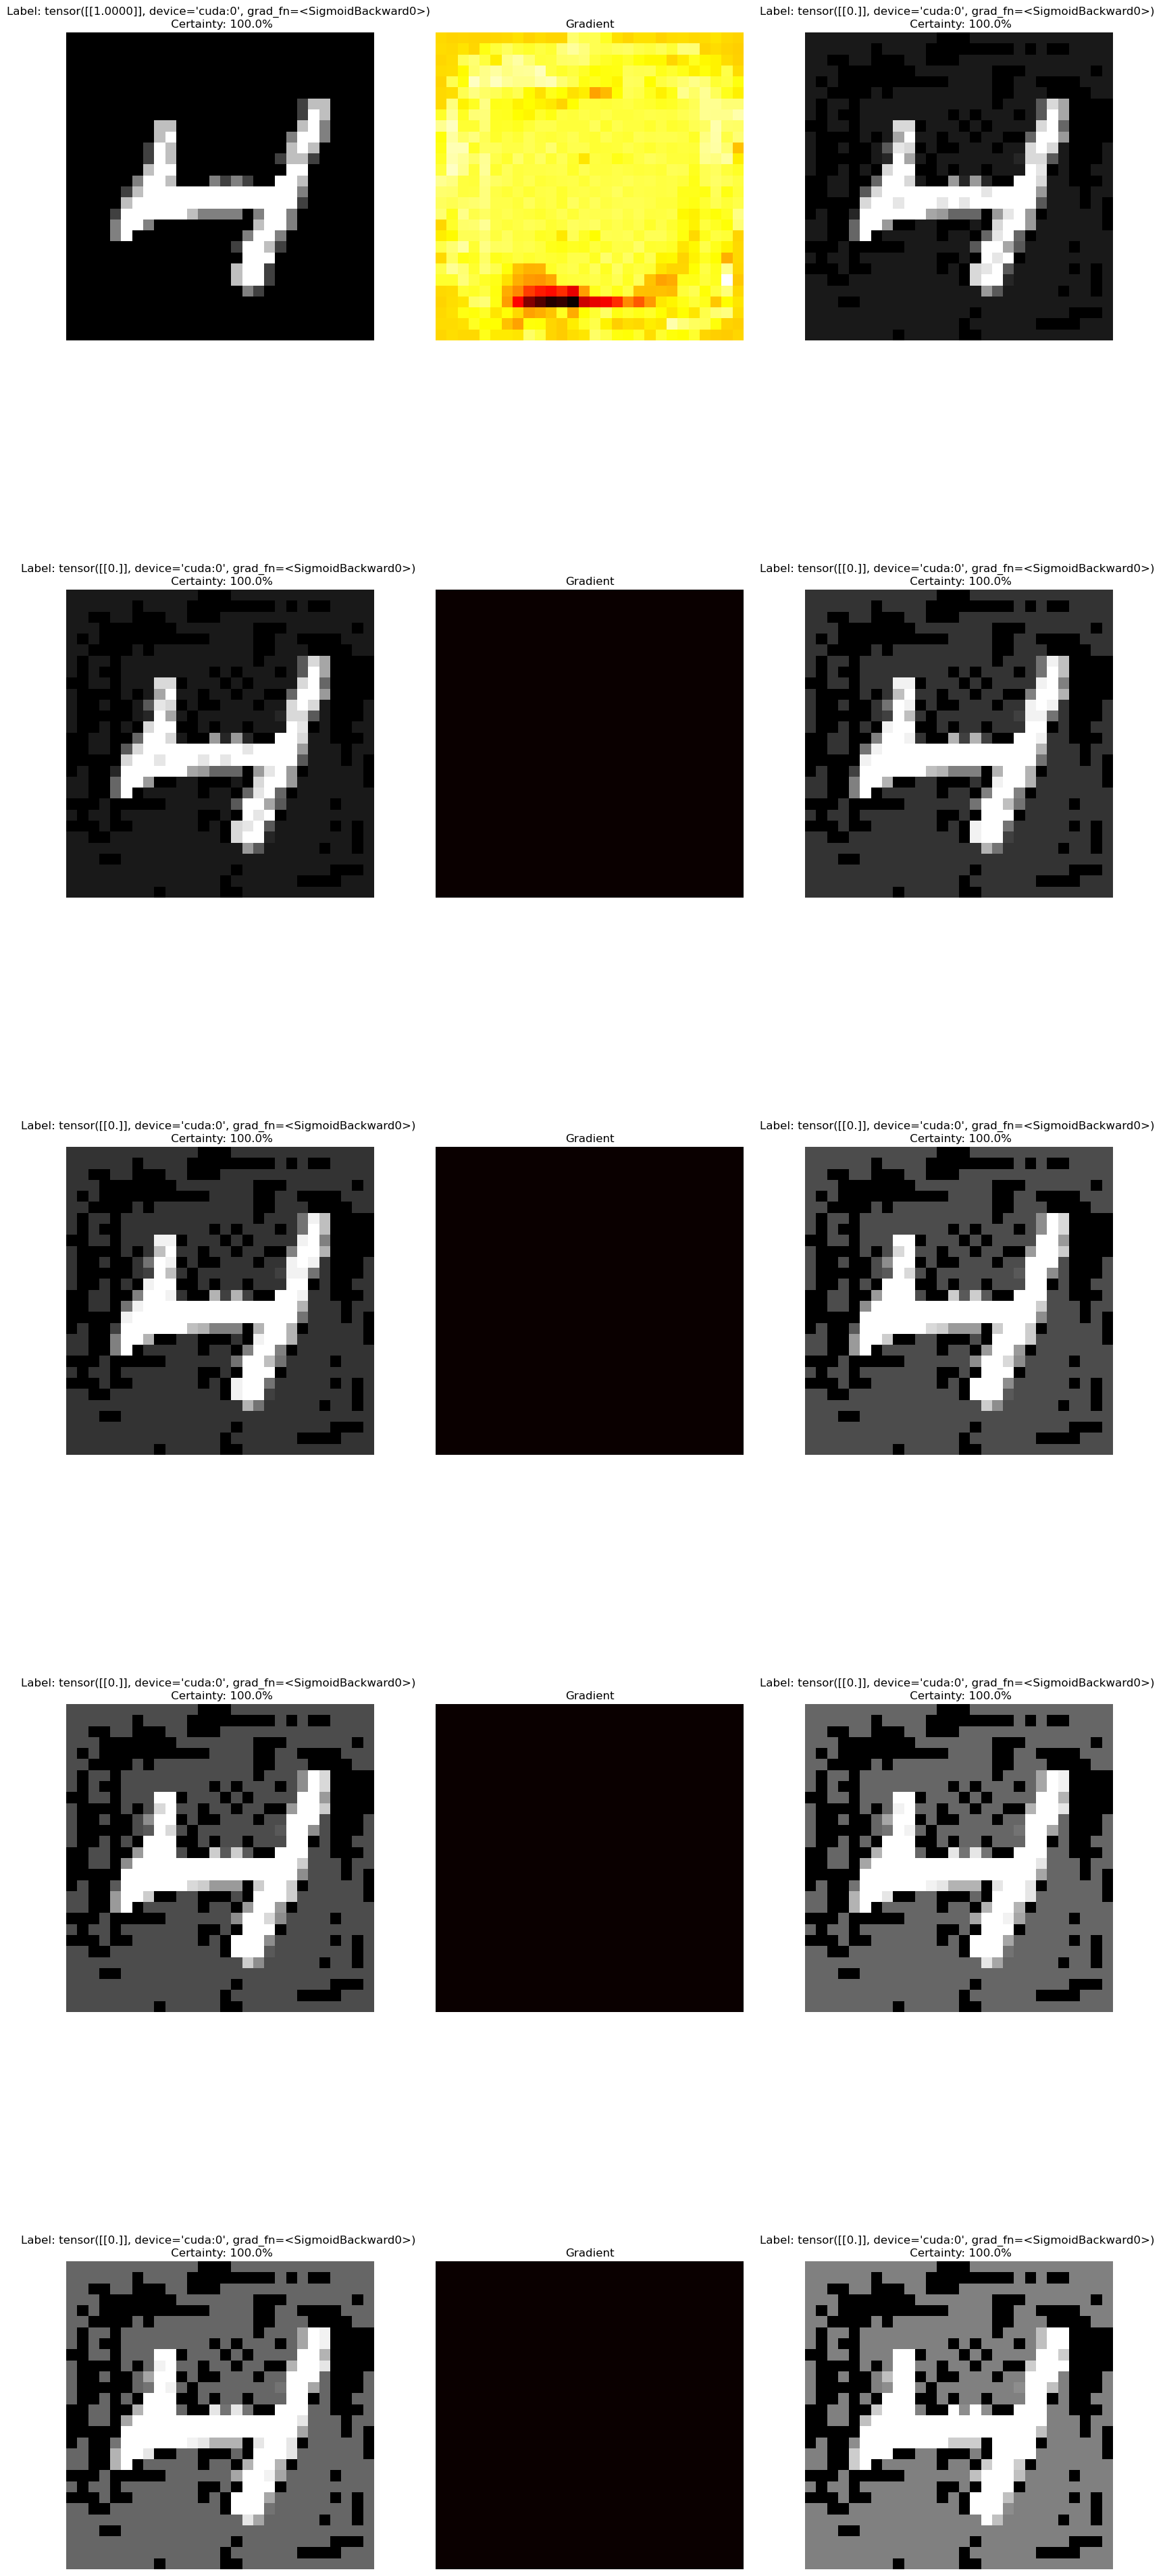

In [18]:
NR_RUNS = 5
random_four = fours[random.randint(0,len(fours)-1)]
fig, axes = plt.subplots(NR_RUNS,3, figsize=(20,10*NR_RUNS))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes):
    random_four.requires_grad_(True)
    output = D(random_four.unsqueeze(0).to(device))
    fool = torch.zeros_like(output)
    loss = my_bce_loss(output, fool.to(device))  # Target: fake
    loss.backward()
    gradients = random_four.grad
    
    _ = random_four.requires_grad_(False)

    probs = F.softmax(output,dim=1).squeeze().tolist()
    #label = torch.argmax(output).item()
    label = output
    #Subtract directional gradient to four
    adv_four = random_four - torch.sign(gradients-random_four)*0.1
    adv_four = torch.clip(adv_four, min=0, max=1)
    
    
    new_output = D(adv_four.to(device).unsqueeze(0))

    
    new_probs = F.softmax(new_output,dim=1).squeeze().tolist()
    #new_label = torch.argmax(new_output).item()
    new_label = new_output
    
    
    ax[0].set_title(f"Label: {label} \n Certainty: {round(probs*100,5)}%")
    ax[1].set_title(f"Gradient")
    ax[2].set_title(f"Label: {new_label} \n Certainty: {round(new_probs*100,5)}%")
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    
    ax[0].imshow(random_four.view(28, 28).detach().cpu(), cmap='gray')
    ax[1].imshow(gradients.view(28, 28).detach().cpu(), cmap='hot')
    ax[2].imshow(adv_four.view(28, 28).detach().cpu(), cmap='gray')
    random_four = adv_four




9


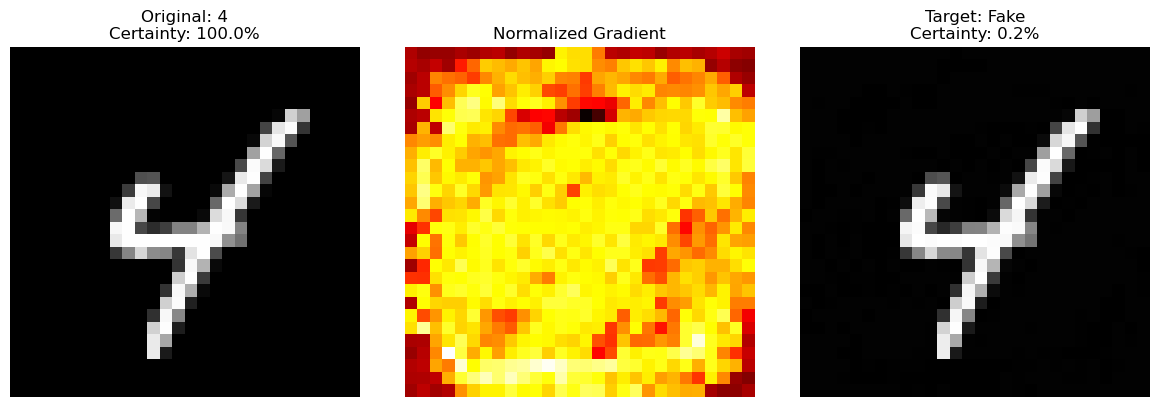

In [139]:
# With not cangeing the pixels of the original position
def create_adv(orig_img, orig_label, target_label, lr, epsilon):
    orig_probs = []
    adv_probs = []
    runs = 0

    while runs < 1e3:
        orig_img.requires_grad_(True)
        output = D(orig_img.unsqueeze(0).to(device))
        loss = my_bce_loss(output, target_label.to(device))
        loss.backward()
        gradients = orig_img.grad

        _ = orig_img.requires_grad_(False)
        gradients = gradients * lr

        probs = output.item()
        orig_probs.append(round(probs * 100, 2))

        adv_img = orig_img - torch.sign(gradients) * lr
        eta = torch.clip(-(adv_img - orig_img), min=-epsilon, max=epsilon)
        adv_img = torch.clip(orig_img - eta, 0, 1)
        #eta = orig_img - torch.sign(gradients-orig_img)*lr
        #adv_img = torch.clip(eta, min=0, max=1)

        new_output = D(adv_img.to(device).unsqueeze(0))
        new_prob = new_output.item()
        adv_probs.append(round(new_prob * 100, 2))

        runs += 1
        orig_img = adv_img

        if new_prob < 0.01:  # Discriminator thinks it's fake (for binary output)
            print(runs)
            return adv_img, orig_probs, adv_probs, runs, gradients

    print("Attack did not succeed within max iterations.")
    return adv_img, orig_probs, adv_probs, runs, gradients


# Select a real image
random_four = fours[random.randint(0, len(fours) - 1)]
orig_img = random_four
output = D(orig_img.unsqueeze(0).to(device))
probs = torch.sigmoid(output).item()

# Hyperparameters
lr = 0.001
epsilon = 0.5
orig_label = 4
target_label = torch.tensor([[0.0]])  # Discriminator target: fake

# Run adversarial attack
adv_img, orig_probs, adv_probs, runs, gradients = create_adv(orig_img, orig_label, target_label, lr, epsilon)

# Normalize gradient for visualization
grad_norm = gradients.view(28, 28).detach().cpu()
grad_norm = (grad_norm - grad_norm.min()) / (grad_norm.max() - grad_norm.min())

# Plot original, gradient, adversarial
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].set_title(f"Original: {orig_label}\nCertainty: {orig_probs[0]}%")
axes[0].axis("off")
axes[0].imshow(orig_img.view(28, 28).detach().cpu(), cmap="gray")

axes[1].set_title("Normalized Gradient")
axes[1].axis("off")
axes[1].imshow(grad_norm, cmap="hot")

axes[2].set_title(f"Target: Fake\nCertainty: {adv_probs[-1]}%")
axes[2].axis("off")
axes[2].imshow(adv_img.view(28, 28).detach().cpu(), cmap="gray")

plt.tight_layout()
plt.show()